# Markovian model of SBB railways

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Clean data contains every "stop" for a year for the IC, IR and RE trains operated by SBB
data = pd.read_pickle('data/istdaten/data_clean_201807-201906.pkl')

In [4]:
# reset index
data = data.reset_index()
data = data.drop(columns=['index'])

In [5]:
data['DELAY_SEC'] = data['DELAY_AB'].dt.total_seconds()
# Transform columns into python datetime to be able to use time function on these (such as dt.weekday, etc)
data['ABFAHRTSZEIT'] = pd.to_datetime(data['ABFAHRTSZEIT'],format="%d.%m.%Y %H:%M")
data['ANKUNFTSZEIT'] = pd.to_datetime(data['ANKUNFTSZEIT'],format="%d.%m.%Y %H:%M")
data['BETRIEBSTAG'] = pd.to_datetime(data['BETRIEBSTAG'],format="%d.%m.%Y")

In [6]:
oct_mon = data[(data['BETRIEBSTAG'].dt.month.isin([10])) & (data['BETRIEBSTAG'].dt.weekday.isin([0]))]

In [7]:
oct_mon

BETRIEBSTAG LINIEN_ID LINIEN_TEXT VERKEHRSMITTEL_TEXT ZUSATZFAHRT_TF  \
1183755  2018-10-01      1056        IC61                  IC          False   
1183756  2018-10-01      1056        IC61                  IC          False   
1183757  2018-10-01      1056        IC61                  IC          False   
1183758  2018-10-01      1056        IC61                  IC          False   
1183759  2018-10-01      1056        IC61                  IC          False   
...             ...       ...         ...                 ...            ...   
1535031  2018-10-29       992        IC61                  IC          False   
1535032  2018-10-29       992        IC61                  IC          False   
1535033  2018-10-29       992        IC61                  IC          False   
1535034  2018-10-29       992        IC61                  IC          False   
1535035  2018-10-29      2902          IC                  IC           True   

        FAELLT_AUS_TF HALTESTELLEN_NAME        ANKUNFTSZEIT  \
1183755         False    Interlaken Ost                 NaT   
1183756         False   Interlaken West 2018-10-01 05:24:00   
1183757         False          Därligen 2018-10-01 05:30:00   
1183758         False         Leissigen 2018-10-01 05:36:00   
1183759         False         Faulensee 2018-10-01 05:43:00   
...               ...               ...                 ...   
1535031         False   Interlaken West 2018-10-29 23:03:00   
1535032         False             Spiez 2018-10-29 23:21:00   
1535033         False              Thun 2018-10-29 23:32:00   
1535034         False              Bern 2018-10-29 23:52:00   
1535035         False      Basel Bad Bf                 NaT   

                 AN_PROGNOSE AN_PROGNOSE_STATUS        ABFAHRTSZEIT  \
1183755                  NaN           PROGNOSE 2018-10-01 05:21:00   
1183756  01.10.2018 05:25:20               REAL 2018-10-01 05:26:00   
1183757  01.10.2018 05:30:46               REAL 2018-10-01 05:30:00   
1183758  01.10.2018 05:35:25               REAL 2018-10-01 05:36:00   
1183759  01.10.2018 05:41:11               REAL 2018-10-01 05:43:00   
...                      ...                ...                 ...   
1535031  29.10.2018 23:03:58               REAL 2018-10-29 23:05:00   
1535032  29.10.2018 23:21:48               REAL 2018-10-29 23:22:00   
1535033  29.10.2018 23:31:30               REAL 2018-10-29 23:33:00   
1535034  29.10.2018 23:53:29               REAL                 NaT   
1535035                  NaN           PROGNOSE 2018-10-29 18:23:00   

                 AB_PROGNOSE AB_PROGNOSE_STATUS DURCHFAHRT_TF  \
1183755  01.10.2018 05:21:33               REAL         False   
1183756  01.10.2018 05:26:47               REAL         False   
1183757  01.10.2018 05:31:48               REAL         False   
1183758  01.10.2018 05:37:08               REAL         False   
1183759  01.10.2018 05:42:33               REAL         False   
...                      ...                ...           ...   
1535031  29.10.2018 23:05:43               REAL         False   
1535032  29.10.2018 23:23:00               REAL         False   
1535033  29.10.2018 23:33:39               REAL         False   
1535034                  NaN           PROGNOSE         False   
1535035                  NaN          UNBEKANNT         False   

                 DELAY_AN          DELAY_AB  DELAY_SEC  
1183755               NaT          00:00:33       33.0  
1183756          00:01:20          00:00:47       47.0  
1183757          00:00:46          00:01:48      108.0  
1183758 -1 days +23:59:25          00:01:08       68.0  
1183759 -1 days +23:58:11 -1 days +23:59:33      -27.0  
...                   ...               ...        ...  
1535031          00:00:58          00:00:43       43.0  
1535032          00:00:48          00:01:00       60.0  
1535033 -1 days +23:59:30          00:00:39       39.0  
1535034          00:01:29               NaT        NaN  
1535035               NaT    

In [174]:
oct_mon['DELAY_SEC'].describe()

count    49180.000000
mean       129.478304
std        154.760687
min      -1556.000000
25%         52.000000
50%         82.000000
75%        150.000000
max       2538.000000
Name: DELAY_SEC, dtype: float64

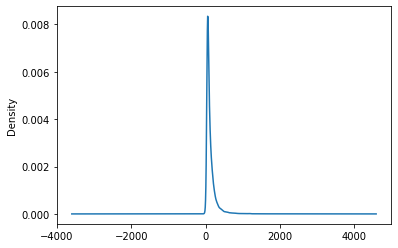

In [8]:
# Probability distribution of delays
oct_mon['DELAY_SEC'].plot.kde();

In [9]:
# Dictionary of long-distance stations
dic = {'station': np.unique(oct_mon['HALTESTELLEN_NAME'])}

In [10]:
stations = pd.DataFrame(dic)

In [37]:
n = stations.shape[0]
n

271

In [59]:
# Initialize a n*n transition matrix
s = (n, n)
matrix = pd.DataFrame(np.zeros(s))

# Initialize a n*1 initial start vector
t = (n)
Initial = pd.DataFrame(np.zeros(t))

In [61]:
# Loop over the dataframe to calculate the initial vector and transition matrix
# It may take a few sec depends on the size

for day in (oct_mon['BETRIEBSTAG'].unique()):
    for route in oct_mon[oct_mon['BETRIEBSTAG']==day]['LINIEN_ID'].unique():
        stops = oct_mon[(oct_mon['BETRIEBSTAG']==day) & (oct_mon['LINIEN_ID']==route)]['HALTESTELLEN_NAME']
        if len(stops)>1:
            pos_i = stations.loc[stations['station'] == stops.iloc[0]].index[0]
            Initial.iloc[pos_i] += 1
            for j in range(len(stops) - 1):
                pos1 = stations.loc[stations['station'] == stops.iloc[j]].index[0]
                pos2 = stations.loc[stations['station'] == stops.iloc[j + 1]].index[0]
                matrix.iloc[pos1, pos2] += 1
            # Add a self-loop if late (>3 minutes)
            temp = oct_mon[(oct_mon['BETRIEBSTAG']==day) & (oct_mon['LINIEN_ID']==route)]
            if temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[j]]['DELAY_SEC'].values[0] > 180:
                matrix.iloc[pos1, pos1] += 1

In [141]:
Initial_dist = Initial.div(Initial.sum(axis=0), axis=1)
Initial_dist.columns = ['Prob']
Initial_dist['Station'] = dic['station']

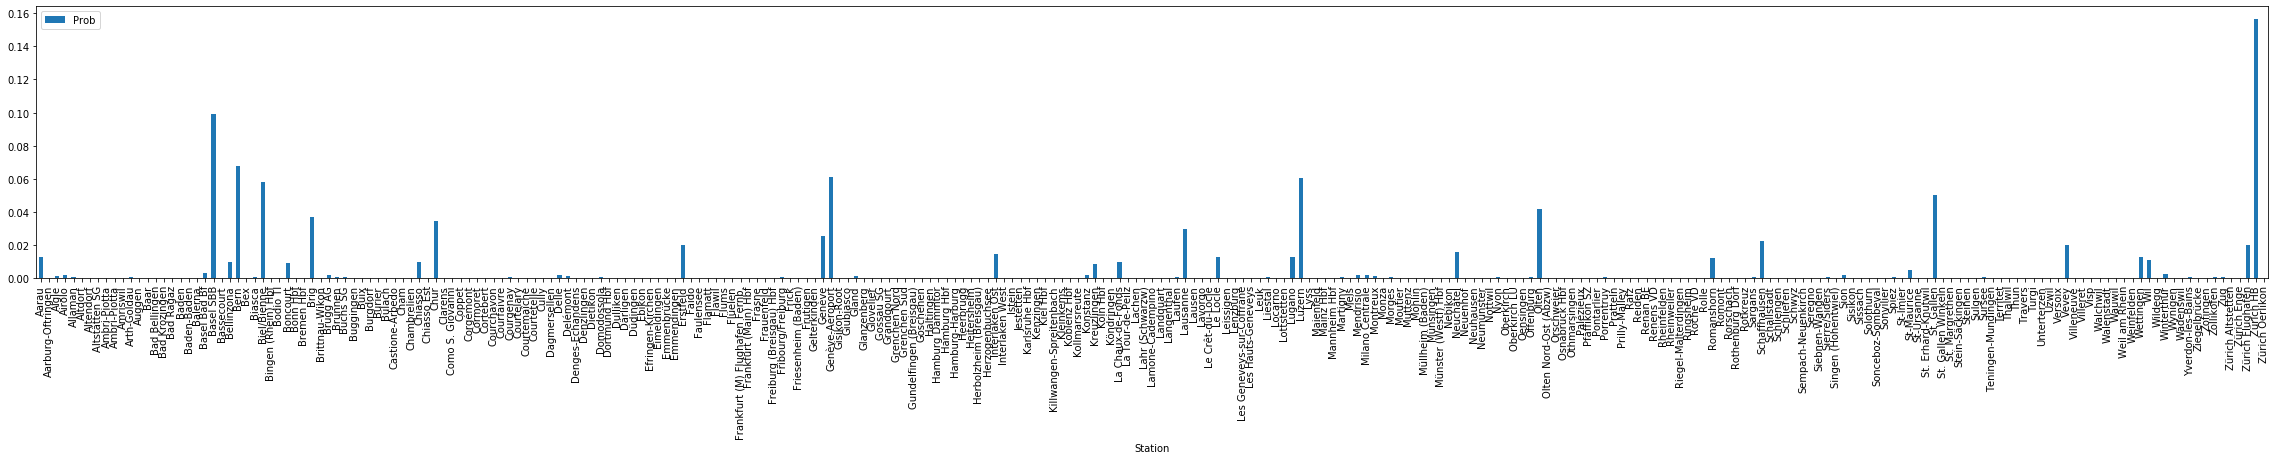

In [142]:
# The most frequent starting stations
Initial_dist.plot.bar(
    x='Station', y='Prob', figsize=(40, 5));

In [241]:
tran_matrix = matrix
tran_matrix = tran_matrix.set_index('Index')

In [242]:
eps

0.001

In [243]:
# Now convert to probabilities
eps = .001
count = 0
for row in tran_matrix.values:
    count+=1
    s = sum(row)
    if s > 0:
        row[:] = [f/sum(row) for f in row]
    if s == 0:
        print('Singularity at', stations.iloc[count]['station'], count)
        print(sum(row))
        row[:] = eps
        row[count] = 1.0
        row[:] = [f/sum(row) for f in row]

Singularity at Altstätten SG 7
0.0
Singularity at Chur 48
0.0
Singularity at Denzlingen 66
0.0
Singularity at Frauenfeld 88
0.0
Singularity at Karlsruhe Hbf 120
0.0
Singularity at Lottstetten 151
0.0
Singularity at Mendrisio 160
0.0
Singularity at Palézieux 187
0.0
Singularity at Uzwil 244
0.0


In [244]:
TM = tran_matrix

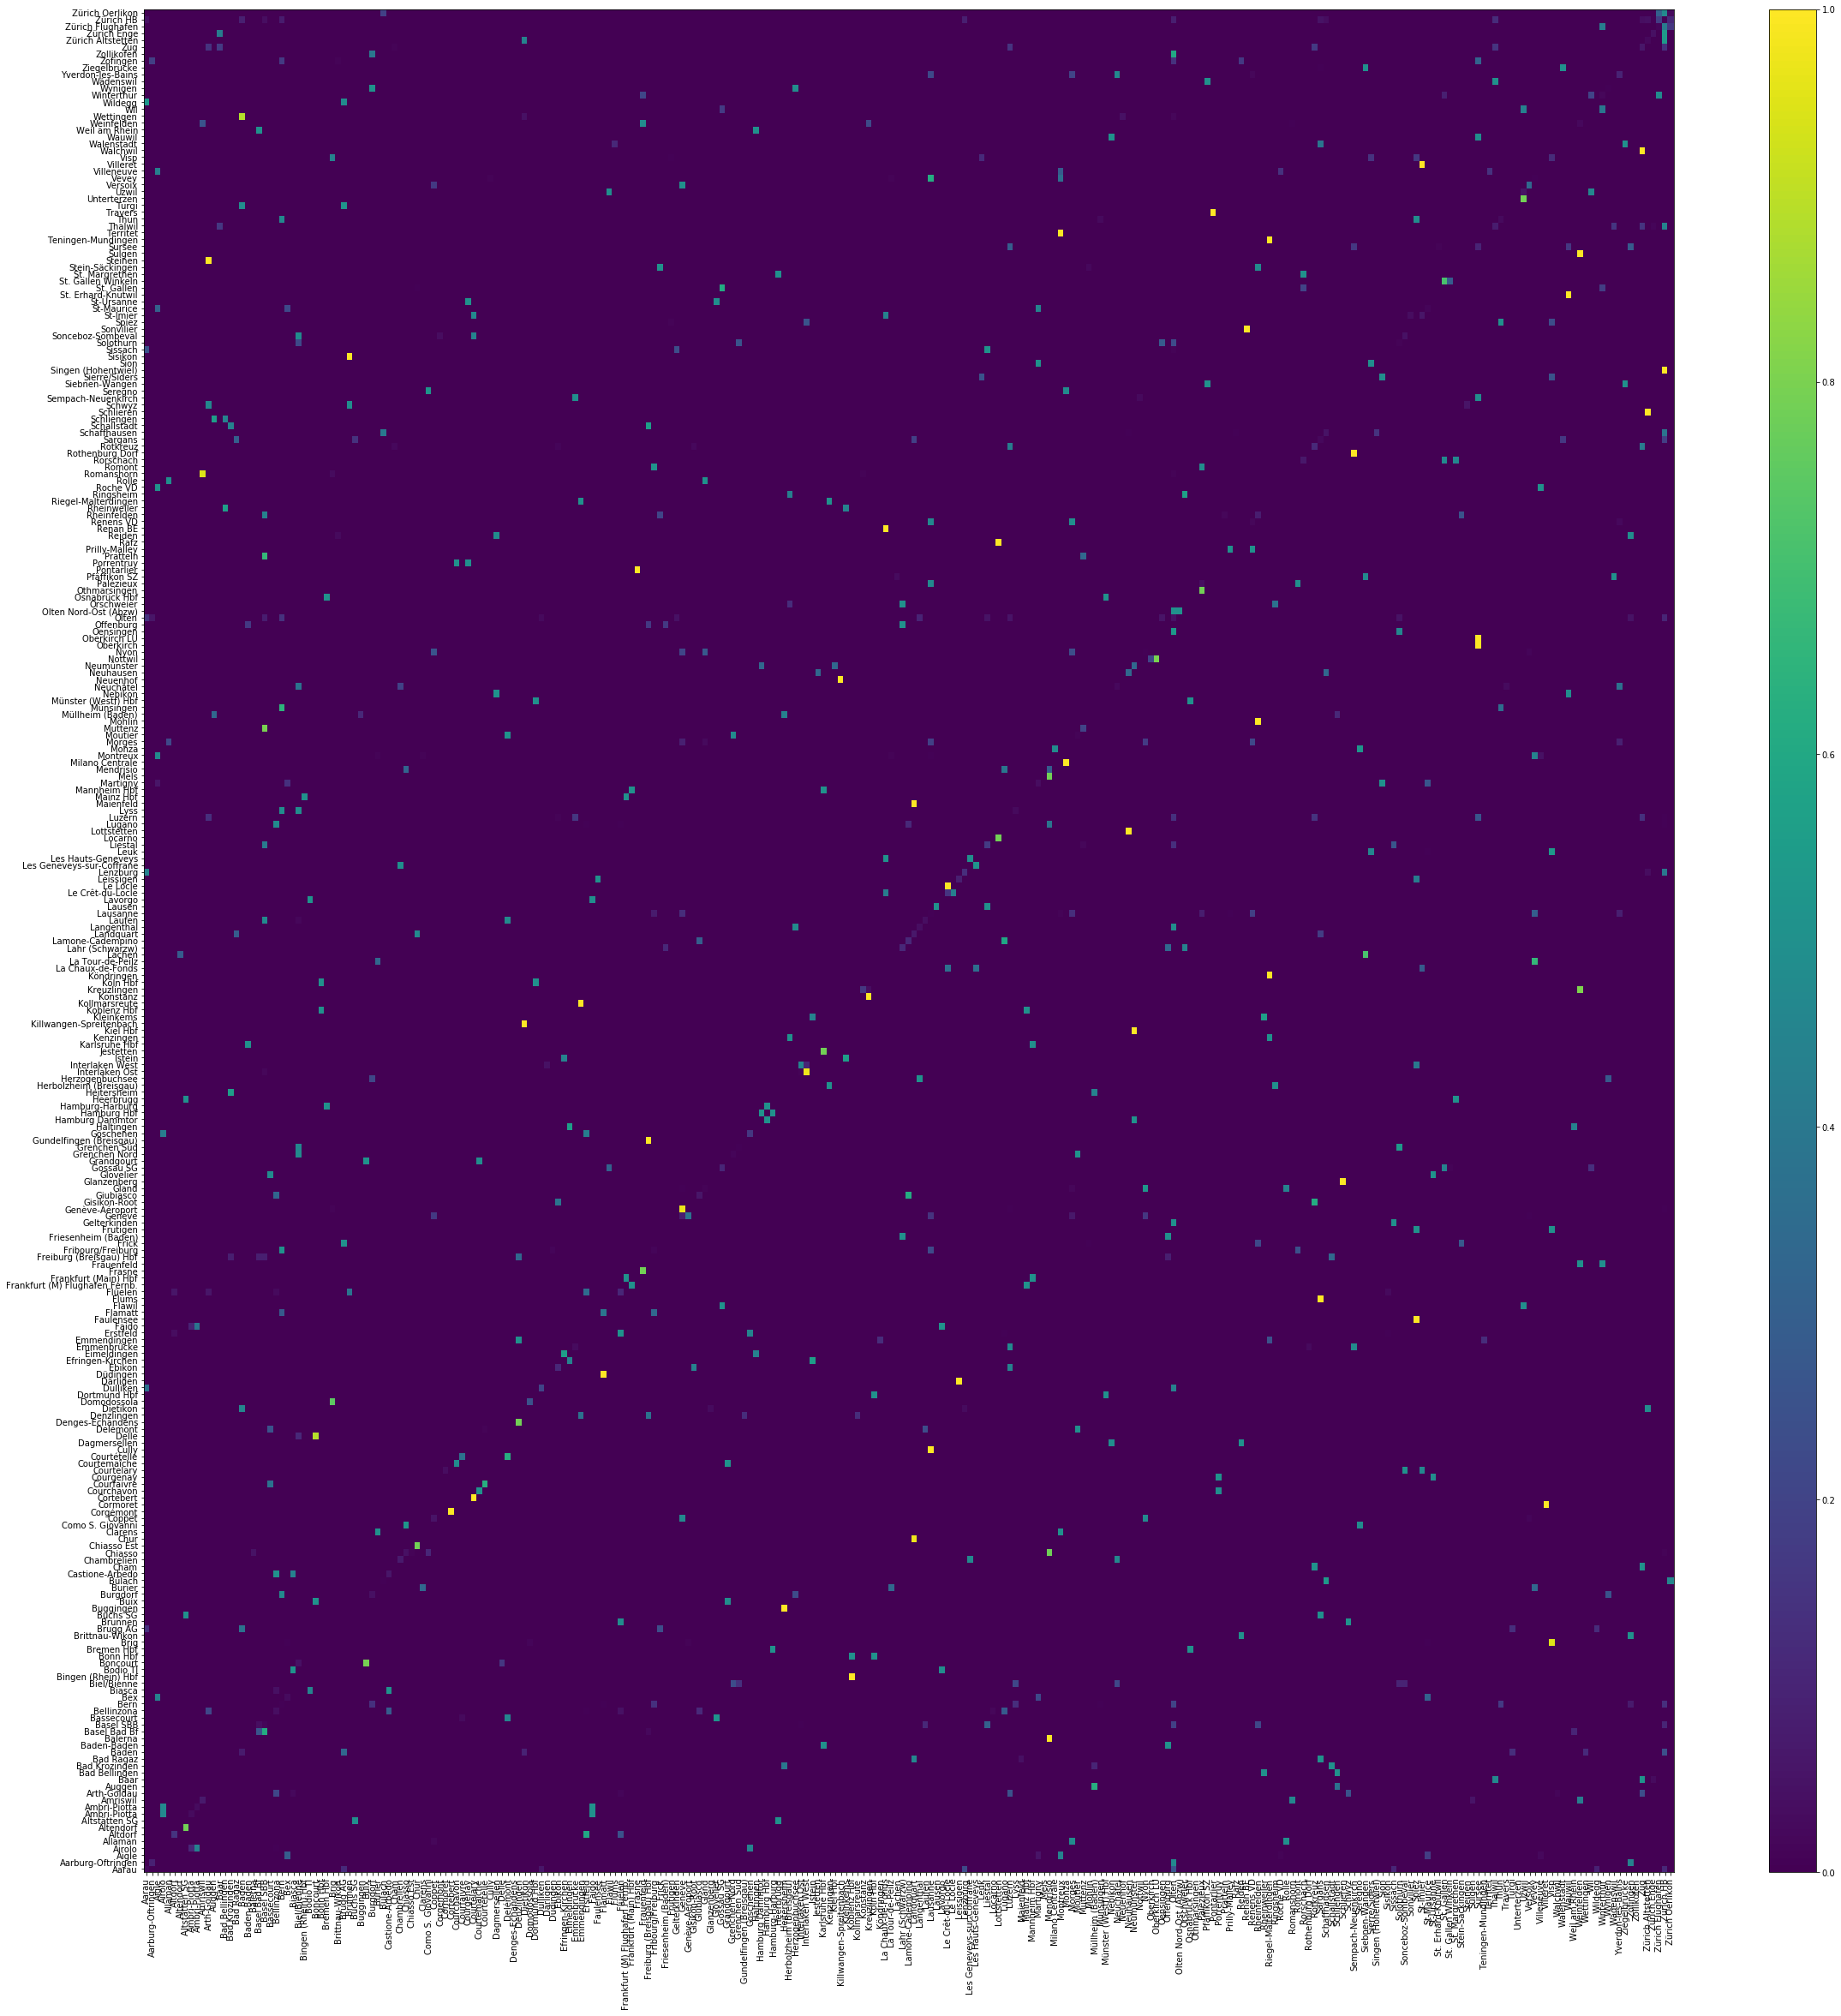

In [246]:
plt.figure(figsize=(40, 40))
plt.pcolor(TM)
plt.yticks(np.arange(0.5, len(dic['station']), 1), TM.index)
plt.xticks(
    np.arange(0.5, len(dic['station']), 1),
    TM.columns,
    rotation='vertical')
plt.colorbar(aspect=40)
plt.show()

## Analysis

In [247]:
from scipy.linalg import norm
import time

In [112]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [115]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 10
Mixing_times_n_times = np.zeros((n, 1))
for i in range(n):
    t, mixing_ = simulate_markov(TM, verbose='off')
    Mixing_times_n_times[i] = mixing_

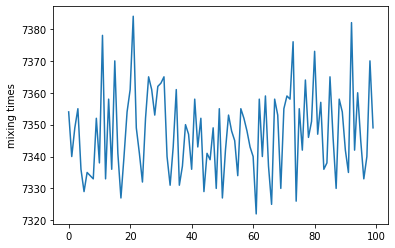

In [118]:
plt.plot(Mixing_times_n_times)
plt.ylabel('mixing times')
plt.show()

In [248]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [249]:
K, pi = Kemeny_constant(TM)

In [250]:
K, np.sum(pi)

(1236.3270945271925, 1.0000000000000002)

In [251]:
Steady_dist = Initial_dist
Steady_dist['Pi'] = pi

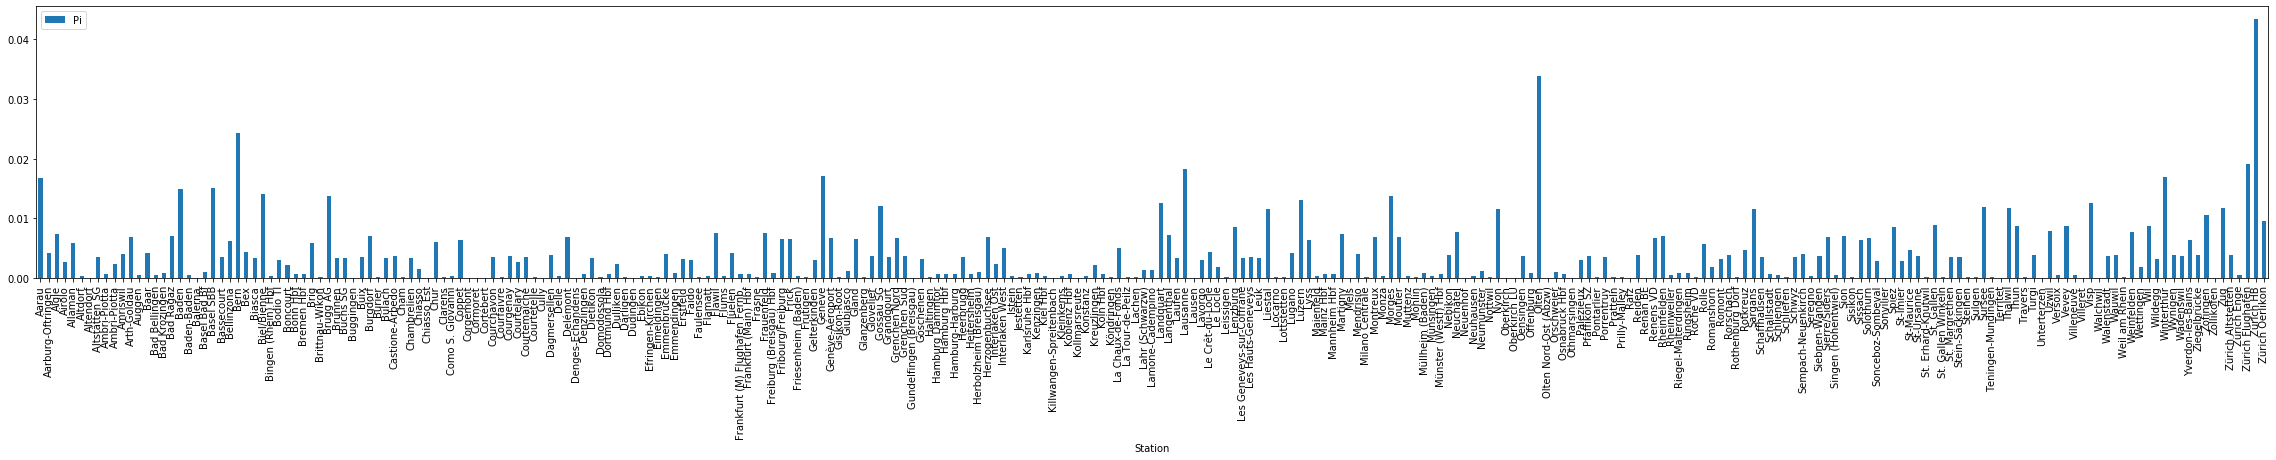

In [252]:
# Steady distribution of stations
Steady_dist.plot.bar(
    x='Station', y='Pi', figsize=(40, 5));

In [254]:
stationrank = Steady_dist.sort_values(['Pi'], ascending=False)

In [255]:
stationrank

Prob           Station            Pi
269  0.156448         Zürich HB  4.340372e-02
182  0.041490             Olten  3.394161e-02
24   0.067653              Bern  2.430363e-02
268  0.019952  Zürich Flughafen  1.905957e-02
139  0.029863          Lausanne  1.820482e-02
..        ...               ...           ...
186  0.000000      Othmarsingen  2.007898e-05
193  0.000000              Rafz  1.853683e-05
47   0.000000       Chiasso Est  1.547550e-05
65   0.000000  Denges-Echandens  1.536970e-05
264  0.000661        Zollikofen  4.599410e-07

[271 rows x 3 columns]

## Network Visualization

In [256]:
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [257]:
# Construct the graph
G = nx.MultiDiGraph()
labels = {}
edge_labels = {}

for i, origin_state in enumerate(list(TM.index)):
    for j, destination_state in enumerate(list(TM.columns)):
        rate = TM.iloc[i, j]
        if rate > 0:
            G.add_edge(
                origin_state,
                destination_state,
                weight=rate,
                label="{:.02f}".format(rate))
            edge_labels[(origin_state,
                         destination_state)] = label = "{:.02f}".format(rate)

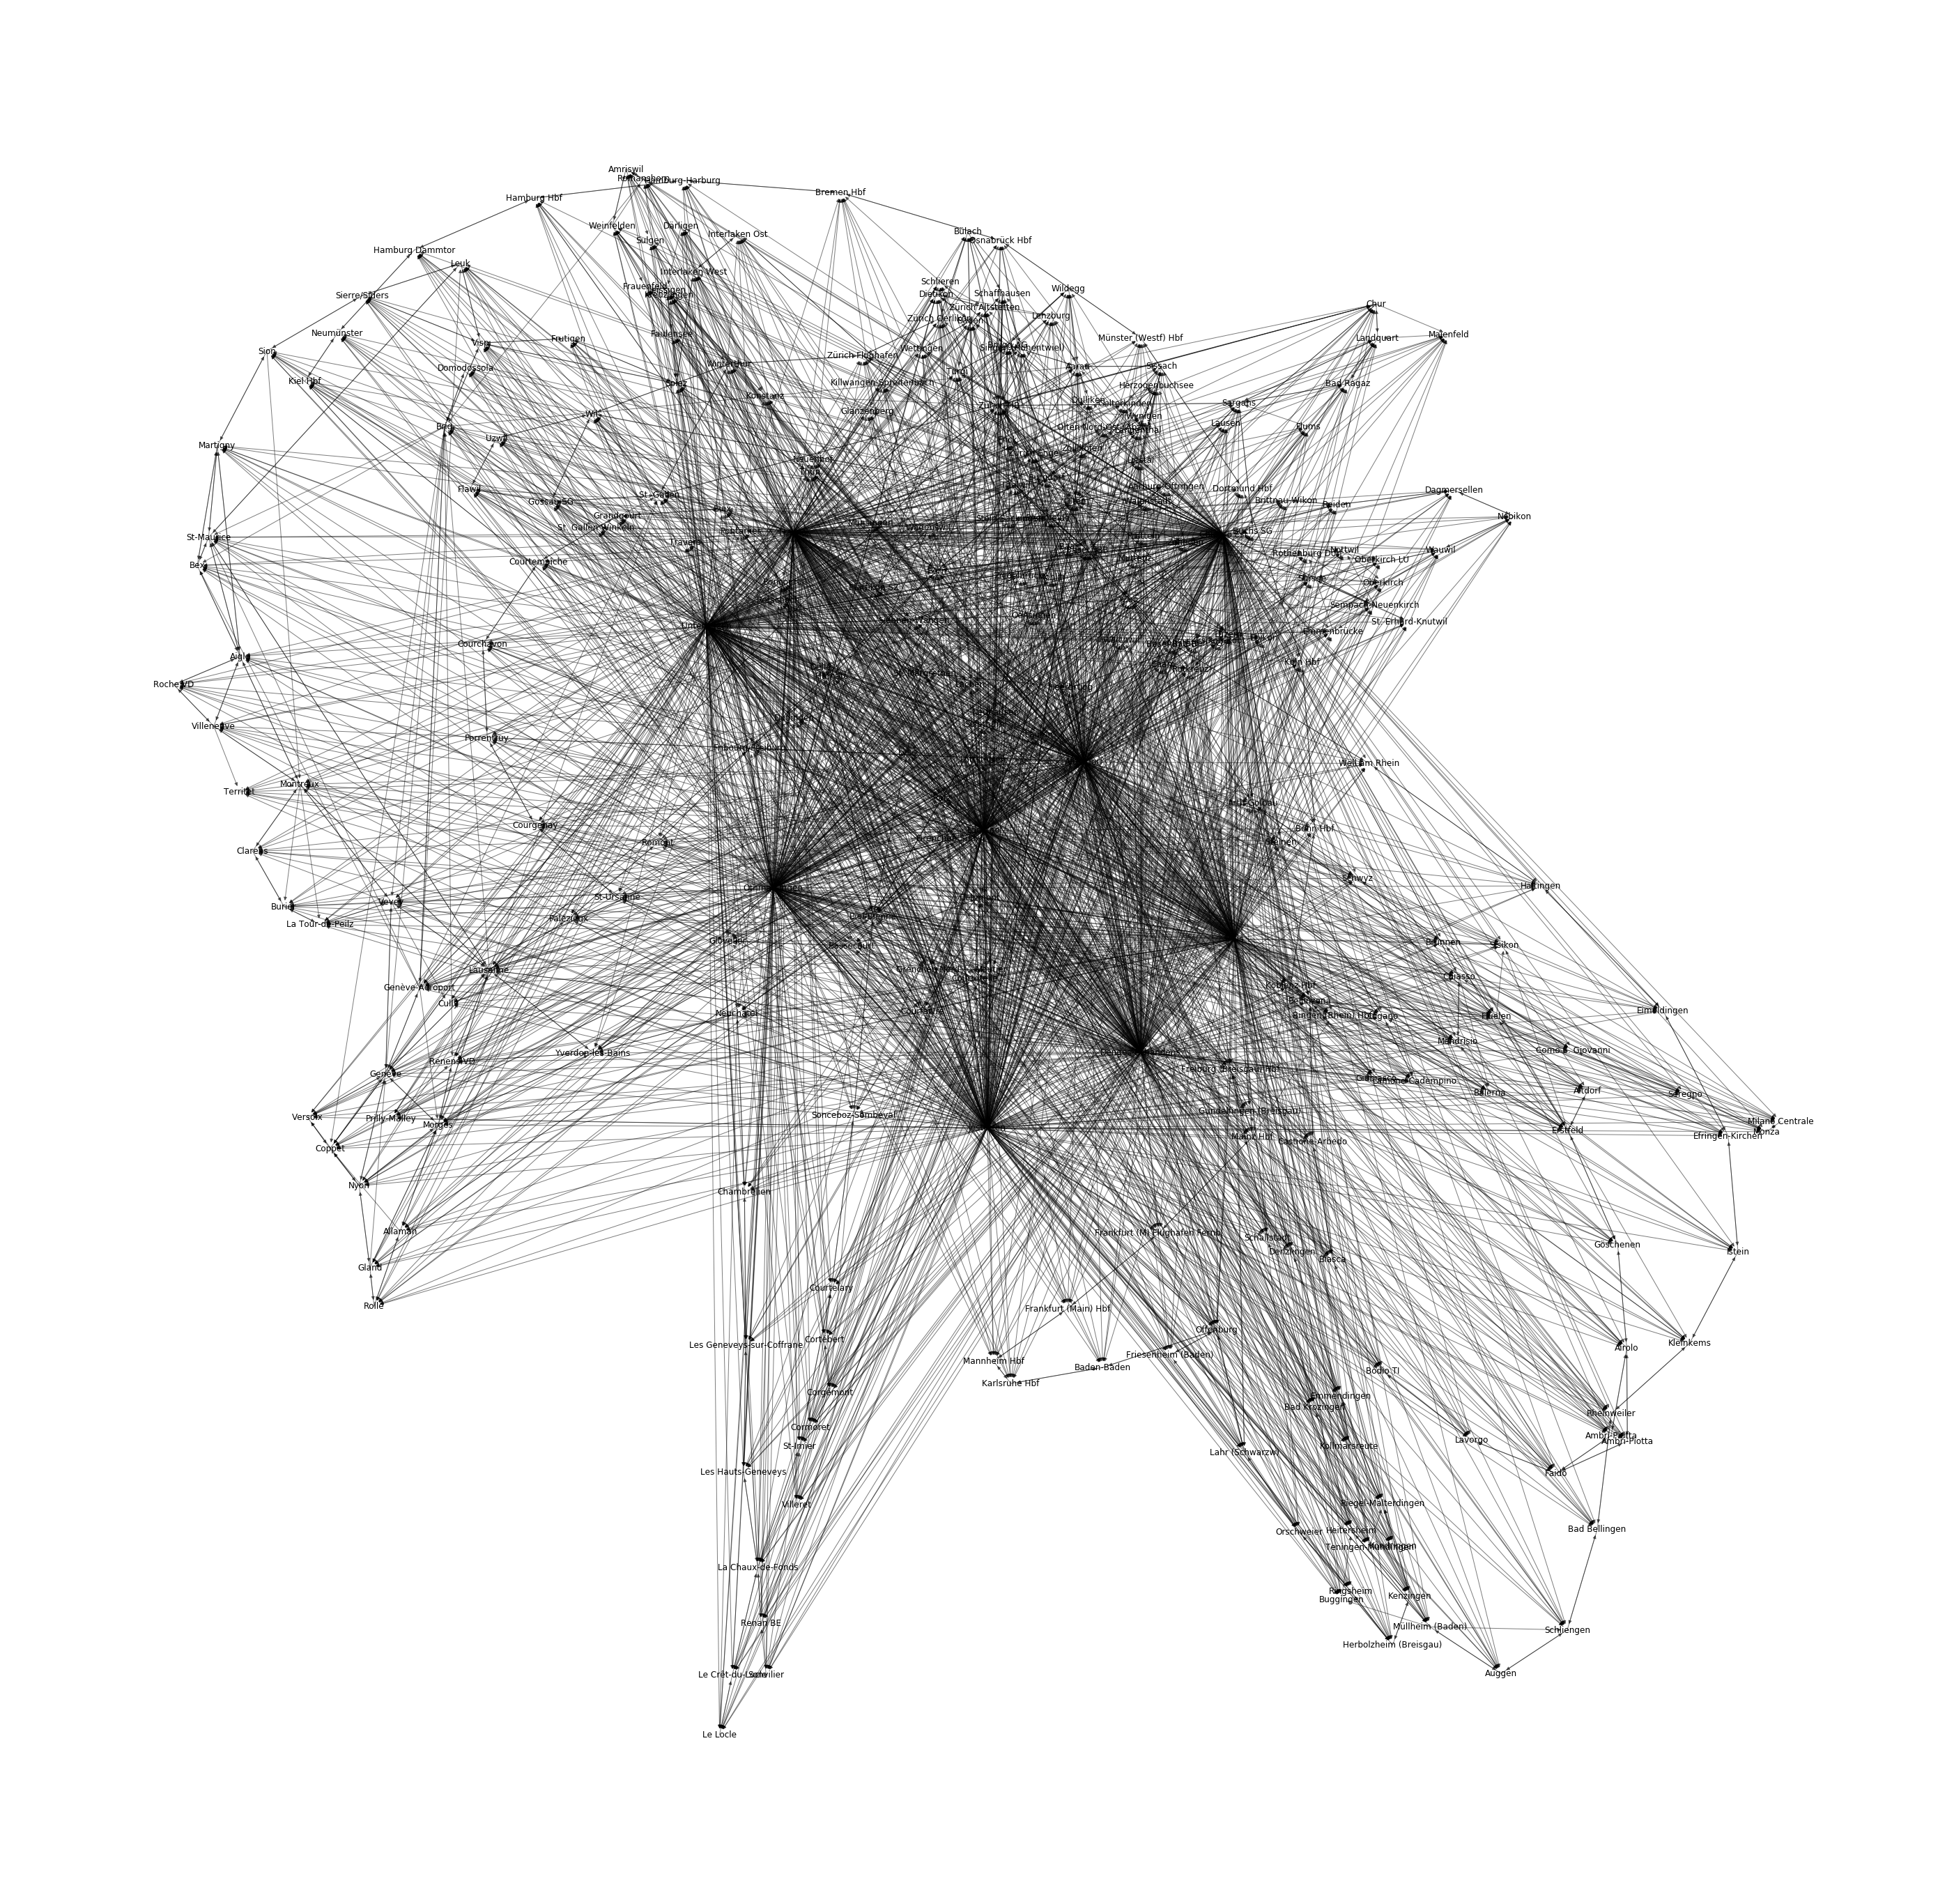

In [258]:
# Draw the graph
plt.figure(figsize=(50, 50))
node_size = 100
pos = nx.spring_layout(G, seed=0)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
plt.axis('off');

In [259]:
import pygraphviz

In [260]:
# Write to file for further visualization
from networkx.drawing.nx_agraph import write_dot
write_dot(G, 'data/mc.dot')

In [261]:
# Inline visualization
from nxpd import draw
from nxpd import nxpdParams
# nxpdParams['show'] = 'external'
nxpdParams['show'] = 'ipynb'

In [ ]:
draw(G)